# Object Detection - Traffic Light Hybrid Detector

#### -- Proof of Concept --

For compatibility with **TensorFlow 1.3**, checkout branch `1f34fcafc1454e0d31ab4a6cc022102a54ac0f5b` for https://github.com/tensorflow/models:

`git clone https://github.com/tensorflow/models.git`

then

`git checkout 1f34fcafc1454e0d31ab4a6cc022102a54ac0f5b`

Follow the [installation instructions](https://github.com/tensorflow/models/blob/1f34fcafc1454e0d31ab4a6cc022102a54ac0f5b/research/object_detection/g3doc/installation.md) before you start.

NOTE: Easiest way to make this notebook runnable is to drop a copy of this into the **your_tensorflow_model_location/models/research/object_detection/ directory**

# Imports

In [41]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import calendar
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
#from object_detection.utils import ops as utils_ops


## Env setup

In [42]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [25]:
#from utils import label_map_util

#from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [51]:
# What model to download.
# These are from git branch 1f34fcafc1454e0d31ab4a6cc022102a54ac0f5b
#MODEL_NAME = 'rfcn_resnet101_coco_2017_11_08' # inference takes ~ 7~11 sec per evaluation...way too slow
#MODEL_NAME = 'faster_rcnn_inception_v2_coco_2017_11_08' # inference takes ~ 5 sec per evaluation...better
MODEL_NAME = 'ssd_inception_v2_coco_2017_11_17' # inference takes ~ 1-2 sec per evaluation...much better!

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

#NUM_CLASSES = 90


## Download Model

In [52]:
if not os.path.exists(MODEL_FILE):    
    print("Downloading {}".format(DOWNLOAD_BASE + MODEL_FILE))
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
      file_name = os.path.basename(file.name)
      if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [53]:
print("CKPT {}".format(PATH_TO_CKPT))
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

CKPT ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [29]:
"""
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
"""

## Helper code

In [46]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [47]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
N = 6
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, N+1) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [48]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
    
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]

  return output_dict

In [49]:
def is_yellow(r, g, b):
    return r > 200 and g > 200 and b < 80

def is_green(r, g, b):
    return r < 70 and g > 120 and b < 90
    
def is_red(r, g, b):
    return r > 120 and g < 50 and b < 50

>>> Image: test_images/image3.jpg...
---Total inference time: 1
box  : [0.44152412 0.16562721 0.6187773  0.2248151 ]
class: 10
score: 0.752134084702


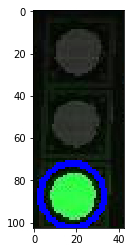

[ 45 255  72]
color: [ 45 255  72]
Green
---Total cv2 time: 0


>>> Image: test_images/image4.jpg...
---Total inference time: 1
box  : [0.00305961 0.34357622 0.20779121 0.49613854]
class: 10
score: 0.77329480648


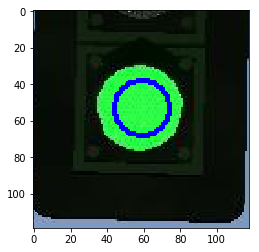

[ 43 250  71]
color: [ 43 250  71]
Green
---Total cv2 time: 0


>>> Image: test_images/image5.jpg...
---Total inference time: 1
box  : [0.2597405  0.4027253  0.53930926 0.49257466]
class: 10
score: 0.819890320301


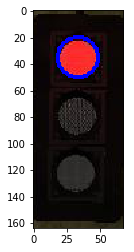

[245  40  35]
color: [245  40  35]
Red
---Total cv2 time: 0


>>> Image: test_images/image6.jpg...
---Total inference time: 2
box  : [0.6006544  0.6277741  0.7517504  0.67404485]
class: 10
score: 0.91958540678


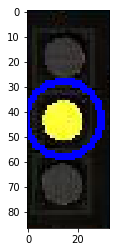

[255 253  54]
color: [255 253  54]
Yellow
---Total cv2 time: 0




In [55]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  print(">>> Image: {}...".format(image_path))
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  #print(image_np.shape)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  inf_start_t = calendar.timegm(time.localtime())
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  time_t = calendar.timegm(time.localtime())
  print("---Total inference time: {}".format(time_t - inf_start_t))

  # CV2 processing to get the color
  cv2_start_t = calendar.timegm(time.localtime())
  boxes = output_dict['detection_boxes']
  clazzes = output_dict['detection_classes']
  scores = output_dict['detection_scores']

  # Get the detected box with the highest score over minimum threshold
  MIN_THRESHOLD = 0.50
  CLASS_TRAFFIC_LIGHT = 10

  max_score_indx = np.argmax(scores)
  score = scores[max_score_indx]
  clazz = clazzes[max_score_indx]
  
  if score > MIN_THRESHOLD and clazz == CLASS_TRAFFIC_LIGHT:
      box = boxes[max_score_indx]
      print("box  : {}".format(box))
      print("class: {}".format(clazz))
      print("score: {}".format(score))
        
      # Determine color of the light
      # box array ([ymin, xmin, ymax, xmax])     
      
      height = image_np.shape[0]
      width = image_np.shape[1]
      # box values are normalized so need to denormalize them
      # to get the right coordinates from the image 
      ymin = int(box[0] * height)
      xmin = int(box[1] * width)
      ymax = int(box[2] * height)
      xmax = int(box[3] * width)
      TRIM = 2
      tl_box = image_np[ymin+TRIM:ymax-TRIM, xmin+TRIM:xmax-TRIM]
      
      tl_box_copy = tl_box.copy()
      gray_tl = cv2.cvtColor(tl_box, cv2.COLOR_RGB2GRAY)
      
      BLUR_RADIUS = 41
      gray_tl = cv2.GaussianBlur(gray_tl, (BLUR_RADIUS, BLUR_RADIUS), 0)
      (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(gray_tl)
      tl_copy = tl_box_copy.copy()
      cv2.circle(tl_copy, maxLoc, 15, (0, 0, 255), 2)
      plt.imshow(tl_copy)
      plt.show()
      
      y,x = maxLoc

      print(tl_copy[x, y, :])
      color = tl_copy[x, y, :]
      r = color[0]
      g = color[1]
      b = color[2]
      print("color: {}".format(color))
      if is_red(r,g,b):
          print("Red")
      elif is_yellow(r,g,b):
          print("Yellow")
      elif is_green(r,g,b):
          print("Green")
      else:
          print("Unknown")
            
  time_t = calendar.timegm(time.localtime())
  print("---Total cv2 time: {}".format(time_t - cv2_start_t))
  print("\n")
    